In [0]:
from google.colab import drive
drive.mount('/gdrive')

KeyboardInterrupt: ignored

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats.mstats import winsorize

In [0]:
fundq = pd.read_csv('/gdrive/My Drive/data/fundq.zip', compression='zip', parse_dates=[0], index_col=[0, 1])
fundq = fundq[fundq['TICKER'].notnull()]

In [0]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [0]:
fundq.head()

TICKER   CAPEI     bm     evm  pe_op_basic  pe_op_dil  \
date       PERMNO                                                         
1970-01-30 10102      AN   7.889  0.790   8.730          NaN        NaN   
           10137     AYP  11.110  0.630   9.757          NaN        NaN   
           10145     ACD   9.049  0.744   7.378          NaN        NaN   
           10161     AMX  13.710  0.581  12.373          NaN        NaN   
           10225     AMB  10.152  0.709   6.552          NaN        NaN   

                   pe_exi  pe_inc     ps     pcf    dpr    npm  opmbd  opmad  \
date       PERMNO                                                              
1970-01-30 10102   10.692  10.692  0.396   4.095  0.000  0.040  0.134  0.077   
           10137    5.039  10.132  1.628   5.225  0.158  0.182  0.472  0.346   
           10145   16.096  36.719  0.492   3.650  0.000  0.041  0.150  0.056   
           10161   11.552  10.614  1.142  16.207  0.006  0.099  0.144  0.098   
           10225    9.199   9.199  0.336  -7.256  0.000  0.037  0.221  0.201   

                     gpm   ptpm    cfm    roa    roe   roce  efftax  \
date       PERMNO                                                     
1970-01-30 10102   0.286  0.061  0.097  0.125  0.066  0.091   0.348   
           10137   0.472  0.286  0.312  0.122  0.138  0.115   0.398   
           10145   0.255  0.052  0.135  0.127  0.053  0.059   0.269   
           10161   0.218  0.134  0.150  0.112  0.135  0.093   0.228   
           10225   0.435  0.089  0.104  0.191  0.129  0.208   0.529   

                   aftret_eq  aftret_invcapx  aftret_equity  pretret_noa  \
date       PERMNO                                                          
1970-01-30 10102       0.080           0.063          0.080        0.084   
           10137       0.135           0.075          0.112        0.100   
           10145       0.055           0.055          0.055        0.062   
           10161       0.140           0.116          0.137        0.101   
           10225       0.131           0.136          0.131        0.243   

                   pretret_earnat  GProf  equity_invcap  debt_invcap  \
date       PERMNO                                                      
1970-01-30 10102            0.076  0.251          0.619        0.381   
           10137            0.092  0.114          0.309        0.558   
           10145            0.052  0.218          0.646        0.354   
           10161            0.086  0.159          0.689        0.294   
           10225            0.185  0.322          0.616        0.305   

                   totdebt_invcap  capital_ratio  int_debt  int_totdebt  \
date       PERMNO                                                         
1970-01-30 10102            0.387          0.381     0.054        0.053   
           10137            0.582          0.558     0.048        0.047   
           10145            0.391          0.354     0.063        0.056   
           10161            0.309          0.294     0.049        0.047   
           10225            0.438          0.331     0.076        0.049   

                   cash_lt  invt_act  rect_act  debt_at  debt_ebitda  \
date       PERMNO                                                      
1970-01-30 10102     0.067     0.504     0.393    0.306        2.531   
           10137       NaN       NaN       NaN    0.510        4.480   
           10145     0.041     0.389     0.547    0.293        2.233   
           10161     0.414     0.358     0.261    0.255        2.434   
           10225     0.057     0.777     0.168    0.334        2.042   

                   short_debt  curr_debt  lt_debt  profit_lct  ocf_lct  \
date       PERMNO                                                        
1970-01-30 10102        0.015      0.209    0.592       1.138    0.737   
           10137        0.041      0.129    0.798       1.441    0.915   
           10145        0.094      0.261    0.515       0.978    0.7

In [0]:
features = fundq.columns[1:-8]

In [0]:
features

Index(['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc',
       'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm',
       'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx',
       'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf',
       'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio',
       'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'DIVYIELD'],
      dtype='object')

In [0]:
# Winsorize to reduce outlier effect when computing (spearman rank or pearson) correlation 
def winsor(series):
    return winsorize(series, limits=[0.02, 0.02])

In [0]:
def normalize_features(group):
#     group[features.tolist()] = group[features.tolist()].apply(winsor, axis=0).copy()
    group[features.tolist()] = ((group[features.tolist()] - group[features.tolist()].mean()) / group[features.tolist()].std()).values
    return group

In [0]:
df = fundq.groupby(level=0).apply(normalize_features)

In [0]:
df.describe()

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,DIVYIELD,VOL,SHROUT,MKTCAP,PRC,RET,RET_shifted,pct_rank,label
count,5.221970e+05,5.384740e+05,5.385840e+05,3.544420e+05,2.204620e+05,5.262220e+05,5.259140e+05,5.390950e+05,5.379070e+05,5.299450e+05,5.390950e+05,5.390630e+05,5.390630e+05,5.389930e+05,5.390950e+05,5.115220e+05,5.379850e+05,5.361680e+05,5.329110e+05,5.280780e+05,5.388260e+05,5.370010e+05,5.388240e+05,4.627180e+05,4.688970e+05,5.395540e+05,5.401160e+05,5.392690e+05,5.387160e+05,5.393180e+05,4.709760e+05,4.744040e+05,5.365720e+05,4.675280e+05,4.680290e+05,5.386770e+05,5.375140e+05,5.273640e+05,4.697780e+05,5.391790e+05,4.683150e+05,4.675620e+05,5.359740e+05,4.867660e+05,5.346510e+05,5.373420e+05,5.395860e+05,5.295040e+05,5.395330e+05,4.791040e+05,4.790600e+05,4.669430e+05,4.649940e+05,4.679270e+05,4.548640e+05,4.656940e+05,5.378200e+05,5.301230e+05,5.124260e+05,5.389410e+05,5.370060e+05,4.521120e+05,5.404400e+05,5.388900e+05,5.388900e+05,5.380480e+05,5.384740e+05,4.737710e+05,4.088840e+05,5.276880e+05,5.412100e+05,5.412100e+05,541210.000000,541210.000000,541210.000000,541210.000000,541210.000000
mean,-3.807682e-18,1.212439e-16,1.917431e-17,2.758001e-17,-2.888991e-17,-2.429223e-18,6.269564e-18,-8.893811e-18,-2.473955e-17,3.434415e-17,1.372223e-16,2.572399e-17,9.564020e-17,6.603719e-17,7.336138e-17,-1.318822e-16,-2.392740e-16,-7.323789e-17,5.925956e-17,-9.612540e-17,-2.171501e-17,-2.408632e-17,1.561268e-17,1.610804e-18,-5.282886e-18,1.460809e-16,-5.495898e-16,3.407431e-16,1.458687e-16,2.888038e-16,4.035569e-17,1.995702e-16,1.343246e-16,1.176386e-17,2.456359e-17,2.058417e-16,-2.488198e-17,2.237531e-16,5.025522e-17,6.744832e-16,1.307783e-17,-1.216334e-16,-5.497031e-17,-2.659316e-18,5.744742e-19,8.008384e-17,-3.657514e-17,1.144504e-16,-2.571455e-17,1.333566e-17,-5.953463e-18,2.033763e-17,-2.297332e-17,-1.922366e-16,-7.941368e-18,2.373380e-18,-9.579967e-17,5.785060e-18,1.292920e-17,-5.403196e-18,6.368748e-18,-1.117917e-17,1.164198e-17,3.432296e-16,-2.826166e-17,6.850208e-17,-2.217089e-17,-2.262622e-17,-3.314508e-17,2.985320e+05,1.825101e+05,7.882747e+06,107.679468,0.018053,0.017004,0.500553,0.020354
std,9.994388e-01,9.994557e-01,9.994558e-01,9.994539e-01,9.993693e-01,9.994430e-01,9.994427e-01,9.994563e-01,9.994551e-01,9.994470e-01,9.994563e-01,9.994563e-01,9.994563e-01,9.994562e-01,9.994563e-01,9.994270e-01,9.994552e-01,9.994534e-01,9.994500e-01,9.994450e-01,9.994561e-01,9.994542e-01,9.994561e-01,9.993666e-01,9.993749e-01,9.994568e-01,9.994574e-01,9.994565e-01,9.994560e-01,9.994566e-01,9.993777e-01,9.993822e-01,9.994538e-01,9.993731e-01,9.993738e-01,9.994559e-01,9.994547e-01,9.994443e-01,9.993761e-01,9.994564e-01,9.993742e-01,9.993731e-01,9.994532e-01,9.993979e-01,9.994518e-01,9.994546e-01,9.994568e-01,9.994465e-01,9.994568e-01,9.993883e-01,9.993882e-01,9.993723e-01,9.993697e-01,9.993736e-01,9.993556e-01,9.993706e-01,9.994551e-01,9.994471e-01,9.994280e-01,9.994562e-01,9.994542e-01,9.993517e-01,9.994577e-01,9.994561e-01,9.994561e-01,9.994553e-01,9.994557e-01,9.993814e-01,9.992832e-01,1.380222e+06,5.711361e+05,2.568818e+07,3167.841019,0.108861,0.106923,0.288667,0.748048
min,-3.571974e+01,-2.021363e+00,-3.776764e+01,-1.463929e+01,-1.240093e+01,-1.300790e+01,-1.188047e+01,-1.045718e+00,-1.237397e+01,-3.629652e+01,-3.780146e+01,-3.782762e+01,-3.780965e+01,-3.734489e+01,-3.761607e+01,-3.759177e+01,-3.188970e+01,-3.394122e+01,-3.625148e+01,-3.188049e+01,-3.624781e+01,-3.588191

In [0]:
training_set = df.loc[:'2012-12-31']
testing_set = df.loc['2012-12-31':]
X, y = training_set[features.tolist()], training_set['label']
X_test, y_test = testing_set[features.tolist()], testing_set['label']

In [0]:
training_set.head()

TICKER     CAPEI        bm       evm  pe_op_basic  \
date       PERMNO                                                     
1970-01-30 10102      AN -0.566124  1.209906 -0.049722          NaN   
           10137     AYP -0.466811  0.619525 -0.044108          NaN   
           10145     ACD -0.530358  1.040171 -0.057112          NaN   
           10161     AMX -0.386646  0.438721 -0.029808          NaN   
           10225     AMB -0.496349  0.911026 -0.061627          NaN   

                   pe_op_dil    pe_exi    pe_inc        ps       pcf  \
date       PERMNO                                                      
1970-01-30 10102         NaN -0.525652 -0.595862 -0.671666 -0.196177   
           10137         NaN -0.873740 -0.635149 -0.038628 -0.176785   
           10145         NaN -0.192896  1.230053 -0.622339 -0.203814   
           10161         NaN -0.472696 -0.601334 -0.288349  0.011679   
           10225         NaN -0.617584 -0.700603 -0.702496 -0.390973   

                        dpr       npm     opmbd     opmad       gpm      ptpm  \
date       PERMNO                                                               
1970-01-30 10102  -0.336791 -0.226419 -0.584434 -0.769637 -0.470484 -0.378830   
           10137   0.175364  0.312462  1.828083  1.574091  0.727335  0.429824   
           10145  -0.336791 -0.222624 -0.470232 -0.952604 -0.670120 -0.411177   
           10161  -0.317342 -0.002518 -0.513058 -0.586669 -0.908396 -0.116467   
           10225  -0.336791 -0.237804  0.036539  0.310743  0.489059 -0.278198   

                        cfm       roa       roe      roce    efftax  \
date       PERMNO                                                     
1970-01-30 10102  -0.201912 -0.660877 -0.352945 -0.821084 -0.092044   
           10137   0.580131 -0.690620 -0.080912 -0.643448  0.002366   
           10145  -0.063690 -0.641048 -0.402062 -1.057931 -0.241212   
           10161  -0.009129 -0.789764 -0.092246 -0.806281 -0.318628   
           10225  -0.176450 -0.006526 -0.114916  0.044891  0.249720   

                   aftret_eq  aftret_invcapx  aftret_equity  pretret_noa  \
date       PERMNO                                                          
1970-01-30 10102   -0.955787       -0.094941      -0.934832    -0.717619   
           10137   -0.186533       -0.086922      -0.478867    -0.643340   
           10145   -1.305448       -0.100286      -1.291055    -0.819752   
           10161   -0.116601       -0.059526      -0.122644    -0.638698   
           10225   -0.242479       -0.046161      -0.208138     0.020526   

                   pretret_earnat     GProf  equity_invcap  debt_invcap  \
date       PERMNO                                                         
1970-01-30 10102        -0.683569 -0.459802      -0.293092     0.298104   
           10137        -0.574449 -0.995626      -1.737219     1.055687   
           10145        -0.847248 -0.588869      -0.167313     0.182540   
           10161        -0.615369 -0.819625       0.033001    -0.074268   
           10225         0.059807 -0.182112      -0.307067    -0.027186   

                   totdebt_invcap  capital_ratio  int_debt  int_totdebt  \
date       PERMNO                                                         
1970-01-30 10102        -0.024085       0.358467 -0.305842    -0.277792   
           10137         0.244148       1.139569 -0.346030    -0.469961   
           10145        -0.018583       0.239316 -0.245560    -0.181708   
           10161        -0.131378      -0.025464 -0.339332    -0.469961   
           10225         0.046068       0.137817 -0.158485    -0.405905   

                    cash_lt  invt_act  rect_act   debt_at  debt_ebitda  \
date       PERMNO                                                        
1970-01-30 10102  -0.475919  0.602713  0.163103  0.226801    -0.014378   
           10137        NaN       NaN       NaN  1.424664     0.091503   
           10145  -0.530557 -0.033436  1.253390  0.150467    -0.0305

In [0]:
train_dates = X.index.get_level_values('date').unique()

In [0]:
def process(group):
    return group.iloc[0, :]

In [0]:
newdf = X.groupby('date').apply(process)

## Set up Time Series CV Folds

In [0]:
def rolling_window_split(df):
    # 5-1 train/test split, 5 folds
    fold_size = np.floor(len(df) / 10).astype(int)
    for i in range(5):
        if i != 4:
            yield (list(range(i*fold_size, (i+5)*fold_size-3)),
                   list(range((i+5)*fold_size+3, (i+6)*fold_size)))
        if i == 4:
            yield (list(range(i*fold_size, (i+5)*fold_size-3)),
                   list(range((i+5)*fold_size+3, len(df))))

In [0]:
for i, (train_index, test_index) in enumerate(rolling_window_split(newdf)):
    print('train {} length:'.format(i+1), len(train_index))
    print('train {}: '.format(i+1), [train_index[0], train_index[-1]])
    print('test {} length:'.format(i+1),len(test_index))
    print('test {}:'.format(i+1), [test_index[0], test_index[-1]])

train 1 length: 252
train 1:  [0, 251]
test 1 length: 48
test 1: [258, 305]
train 2 length: 252
train 2:  [51, 302]
test 2 length: 48
test 2: [309, 356]
train 3 length: 252
train 3:  [102, 353]
test 3 length: 48
test 3: [360, 407]
train 4 length: 252
train 4:  [153, 404]
test 4 length: 48
test 4: [411, 458]
train 5 length: 252
train 5:  [204, 455]
test 5 length: 54
test 5: [462, 515]


In [0]:
for i, (train_index, test_index) in enumerate(rolling_window_split(newdf)):
    print('train {} length:'.format(i+1), len(train_index))
    print('train {}: '.format(i+1), [train_dates[train_index[0]].strftime('%Y-%m-%d'), 
                                     train_dates[train_index[-1]].strftime('%Y-%m-%d')])
    print('test {} length:'.format(i+1),len(test_index))
    print('test {}:'.format(i+1), [train_dates[test_index[0]].strftime('%Y-%m-%d'), 
                                   train_dates[test_index[-1]].strftime('%Y-%m-%d')])

train 1 length: 252
train 1:  ['1970-01-30', '1990-12-31']
test 1 length: 48
test 1: ['1991-07-31', '1995-06-30']
train 2 length: 252
train 2:  ['1974-04-30', '1995-03-31']
test 2 length: 48
test 2: ['1995-10-31', '1999-09-30']
train 3 length: 252
train 3:  ['1978-07-31', '1999-06-30']
test 3 length: 48
test 3: ['2000-01-31', '2003-12-31']
train 4 length: 252
train 4:  ['1982-10-29', '2003-09-30']
test 4 length: 48
test 4: ['2004-04-30', '2008-03-31']
train 5 length: 252
train 5:  ['1987-01-30', '2007-12-31']
test 5 length: 54
test 5: ['2008-07-31', '2012-12-31']


In [0]:
## Extract first training fold for analysis
for i, (train_index, test_index) in enumerate(rolling_window_split(newdf)):
    print('train {} length:'.format(i+1), len(train_index))
    print('train {}: '.format(i+1), [train_dates[train_index[0]].strftime('%Y-%m-%d'), 
                                     train_dates[train_index[-1]].strftime('%Y-%m-%d')])
    print('test {} length:'.format(i+1),len(test_index))
    print('test {}:'.format(i+1), [train_dates[test_index[0]].strftime('%Y-%m-%d'), 
                                   train_dates[test_index[-1]].strftime('%Y-%m-%d')])
    break

train 1 length: 252
train 1:  ['1970-01-30', '1990-12-31']
test 1 length: 48
test 1: ['1991-07-31', '1995-06-30']


In [0]:
fold_1 = training_set.loc[train_dates[train_index[0]].strftime('%Y-%m-%d'):
                          train_dates[train_index[-1]].strftime('%Y-%m-%d')].copy()

In [0]:
fold_1.head()

TICKER     CAPEI        bm       evm  pe_op_basic  \
date       PERMNO                                                     
1970-01-30 10102      AN -0.566124  1.209906 -0.049722          NaN   
           10137     AYP -0.466811  0.619525 -0.044108          NaN   
           10145     ACD -0.530358  1.040171 -0.057112          NaN   
           10161     AMX -0.386646  0.438721 -0.029808          NaN   
           10225     AMB -0.496349  0.911026 -0.061627          NaN   

                   pe_op_dil    pe_exi    pe_inc        ps       pcf  \
date       PERMNO                                                      
1970-01-30 10102         NaN -0.525652 -0.595862 -0.671666 -0.196177   
           10137         NaN -0.873740 -0.635149 -0.038628 -0.176785   
           10145         NaN -0.192896  1.230053 -0.622339 -0.203814   
           10161         NaN -0.472696 -0.601334 -0.288349  0.011679   
           10225         NaN -0.617584 -0.700603 -0.702496 -0.390973   

                        dpr       npm     opmbd     opmad       gpm      ptpm  \
date       PERMNO                                                               
1970-01-30 10102  -0.336791 -0.226419 -0.584434 -0.769637 -0.470484 -0.378830   
           10137   0.175364  0.312462  1.828083  1.574091  0.727335  0.429824   
           10145  -0.336791 -0.222624 -0.470232 -0.952604 -0.670120 -0.411177   
           10161  -0.317342 -0.002518 -0.513058 -0.586669 -0.908396 -0.116467   
           10225  -0.336791 -0.237804  0.036539  0.310743  0.489059 -0.278198   

                        cfm       roa       roe      roce    efftax  \
date       PERMNO                                                     
1970-01-30 10102  -0.201912 -0.660877 -0.352945 -0.821084 -0.092044   
           10137   0.580131 -0.690620 -0.080912 -0.643448  0.002366   
           10145  -0.063690 -0.641048 -0.402062 -1.057931 -0.241212   
           10161  -0.009129 -0.789764 -0.092246 -0.806281 -0.318628   
           10225  -0.176450 -0.006526 -0.114916  0.044891  0.249720   

                   aftret_eq  aftret_invcapx  aftret_equity  pretret_noa  \
date       PERMNO                                                          
1970-01-30 10102   -0.955787       -0.094941      -0.934832    -0.717619   
           10137   -0.186533       -0.086922      -0.478867    -0.643340   
           10145   -1.305448       -0.100286      -1.291055    -0.819752   
           10161   -0.116601       -0.059526      -0.122644    -0.638698   
           10225   -0.242479       -0.046161      -0.208138     0.020526   

                   pretret_earnat     GProf  equity_invcap  debt_invcap  \
date       PERMNO                                                         
1970-01-30 10102        -0.683569 -0.459802      -0.293092     0.298104   
           10137        -0.574449 -0.995626      -1.737219     1.055687   
           10145        -0.847248 -0.588869      -0.167313     0.182540   
           10161        -0.615369 -0.819625       0.033001    -0.074268   
           10225         0.059807 -0.182112      -0.307067    -0.027186   

                   totdebt_invcap  capital_ratio  int_debt  int_totdebt  \
date       PERMNO                                                         
1970-01-30 10102        -0.024085       0.358467 -0.305842    -0.277792   
           10137         0.244148       1.139569 -0.346030    -0.469961   
           10145        -0.018583       0.239316 -0.245560    -0.181708   
           10161        -0.131378      -0.025464 -0.339332    -0.469961   
           10225         0.046068       0.137817 -0.158485    -0.405905   

                    cash_lt  invt_act  rect_act   debt_at  debt_ebitda  \
date       PERMNO                                                        
1970-01-30 10102  -0.475919  0.602713  0.163103  0.226801    -0.014378   
           10137        NaN       NaN       NaN  1.424664     0.091503   
           10145  -0.530557 -0.033436  1.253390  0.150467    -0.0305

## Distribution of each feature

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


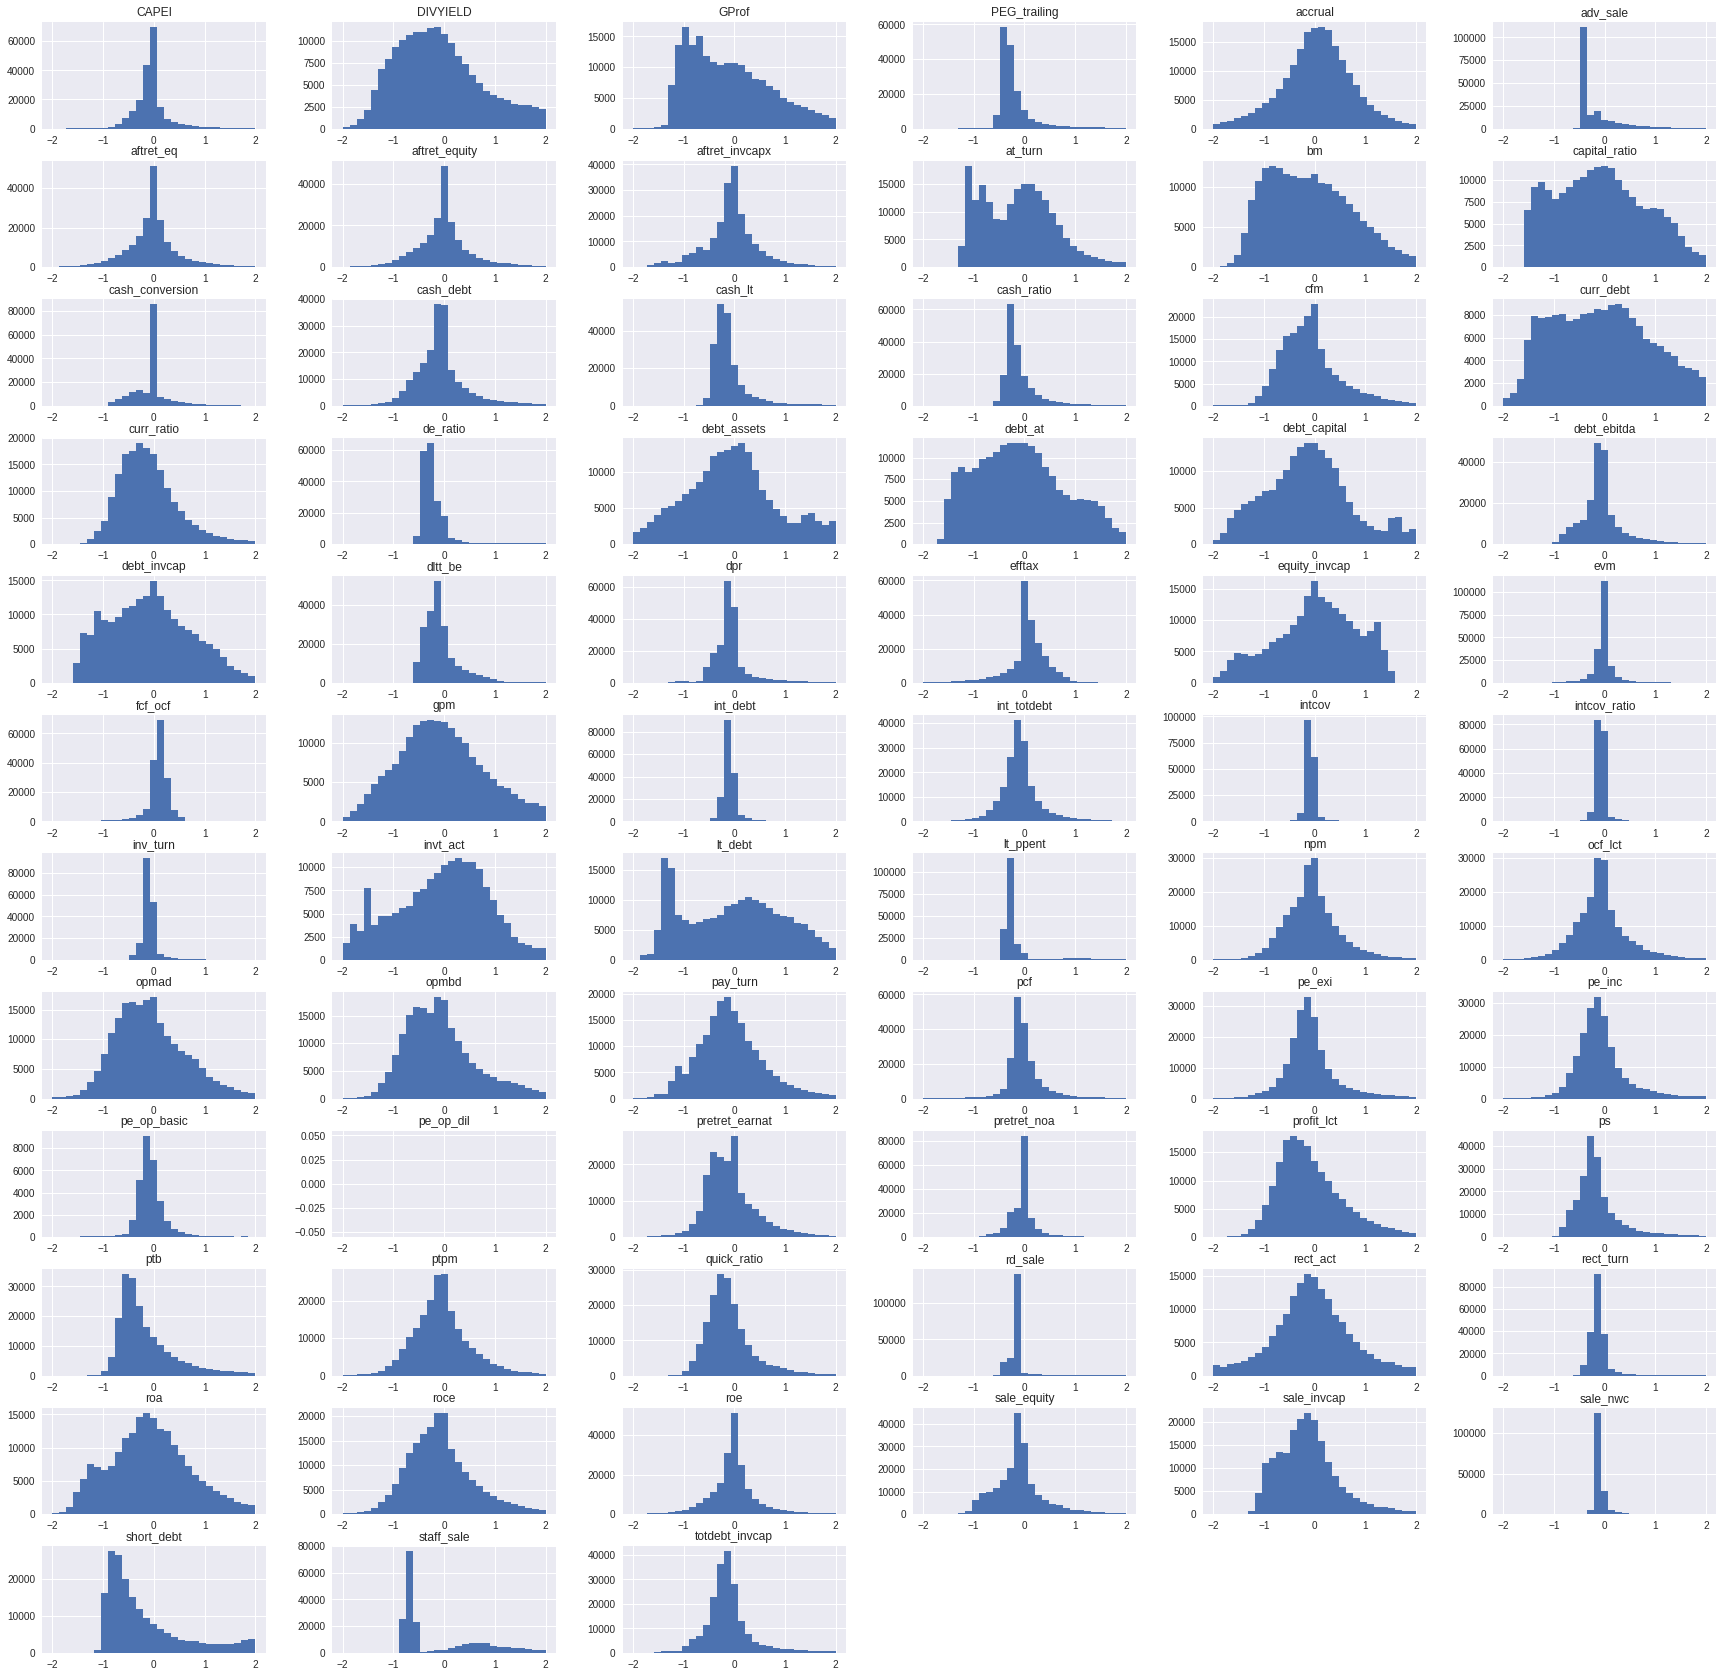

In [0]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
fold_1[features].hist(layout=(12, 6), bins=np.linspace(-2,2,30), ax=ax);

## Correlation of features

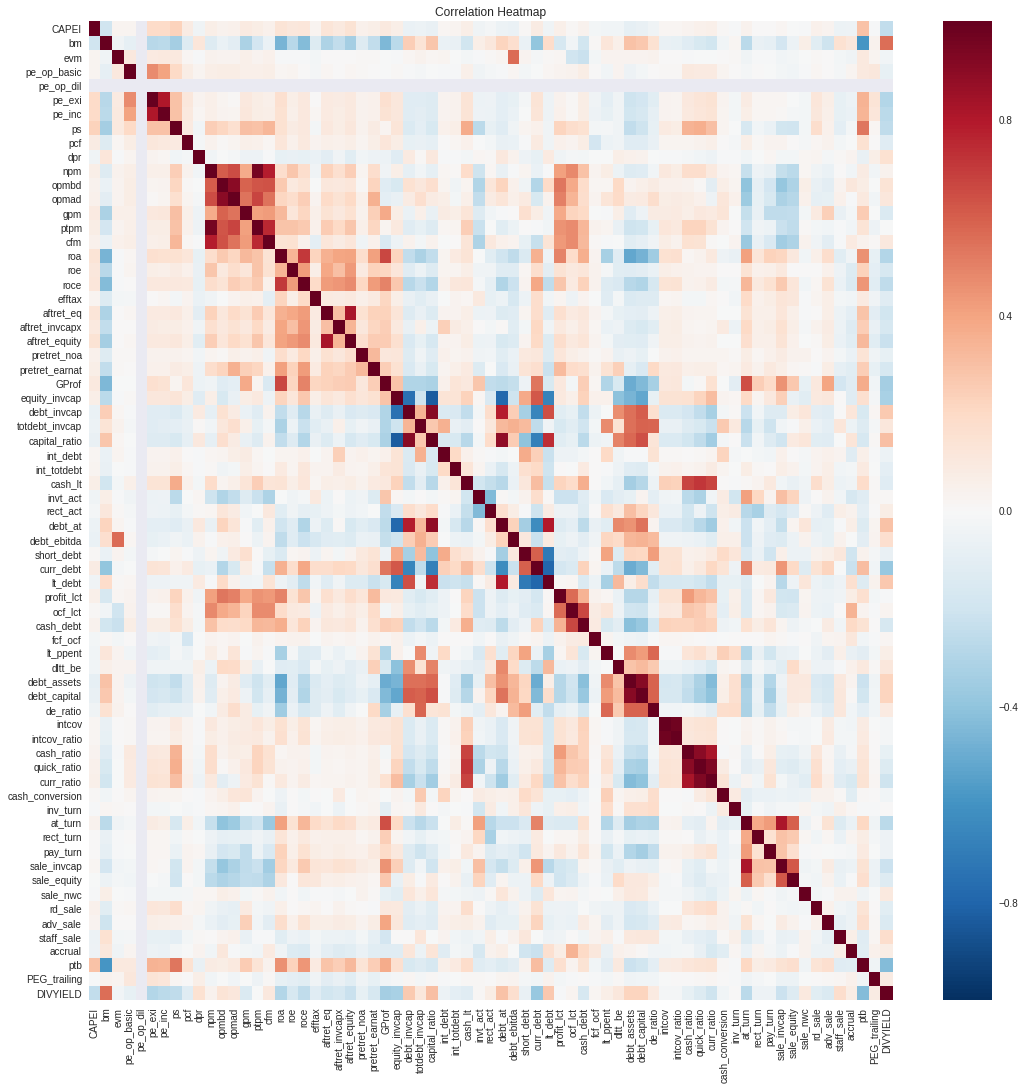

<Figure size 576x396 with 0 Axes>

In [0]:
import seaborn as sns
plt.figure(figsize = (18,18))
sns.heatmap(data=fold_1[features].corr())
plt.title('Correlation Heatmap')
plt.show()
plt.gcf().clear()

### Top Correlated Features

In [0]:
c = fold_1[features].corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort").reset_index()
so.columns = ['col_1','col_2', 'corr']
so = so.sort_values(by = ['corr', 'col_1'], ascending = False)
so = so[so['corr']!=1]
so = so.iloc[::2].reset_index(drop=True)
so

,col_1,col_2,corr
0,intcov_ratio,intcov,0.973472
1,ptpm,npm,0.955171
2,quick_ratio,curr_ratio,0.932189
3,debt_capital,debt_assets,0.913498
4,debt_invcap,capital_ratio,0.907779
5,quick_ratio,cash_ratio,0.904632
6,opmbd,opmad,0.903150
7,debt_at,capital_ratio,0.890245
8,equity_invcap,capital_ratio,0.835863
9,aftret_equity,aftret_eq,0.827728


### Top features with highest proportion of NaNs

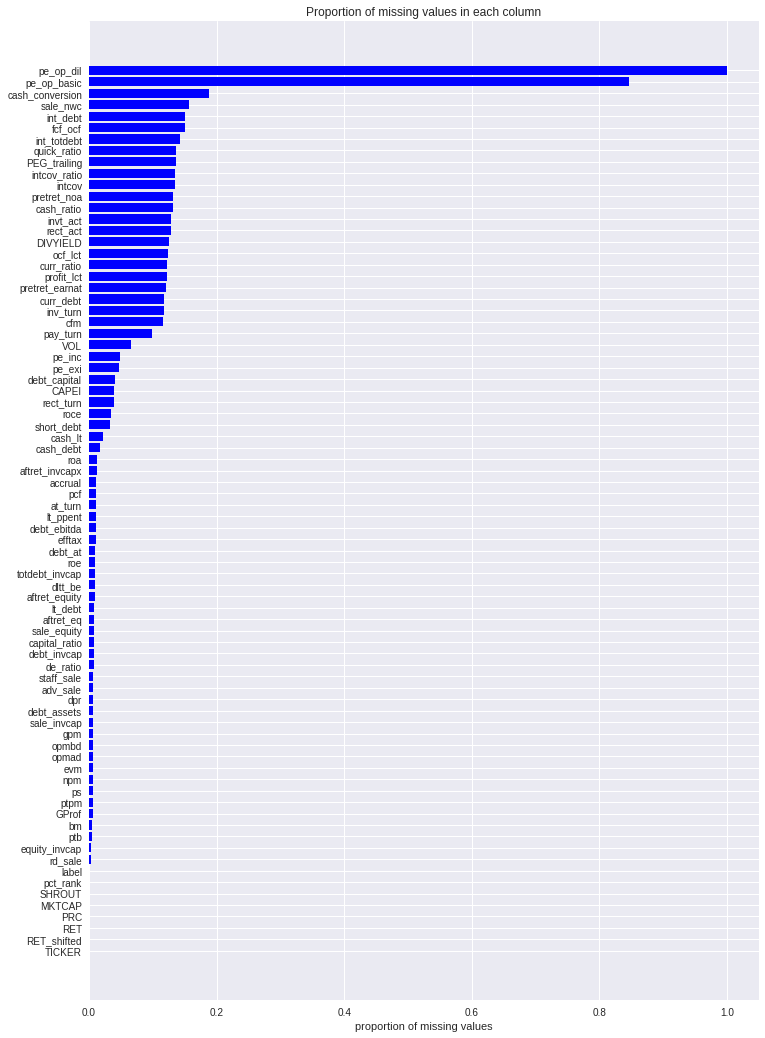

In [0]:
num_na = (fold_1.isnull().sum() / len(fold_1)).reset_index()
num_na.columns = ['field','proportion']
num_na = num_na.sort_values(by = 'proportion', ascending = True)
ind = np.arange(num_na.shape[0])
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, num_na.proportion.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(num_na.field.values, rotation='horizontal')
ax.set_xlabel("proportion of missing values")
ax.set_title("Proportion of missing values in each column")
plt.show()

In [0]:
num_na.sort_values(by = 'proportion', ascending = False)

,field,proportion
5,pe_op_dil,1.000000
4,pe_op_basic,0.846280
55,cash_conversion,0.187289
62,sale_nwc,0.157339
31,int_debt,0.151167
44,fcf_ocf,0.149737
32,int_totdebt,0.142475
53,quick_ratio,0.136603
68,PEG_trailing,0.135673
51,intcov_ratio,0.134675


## Top most predictive features

In [0]:
## Discard columns with high missing values (>80%)
features = [x for x in features if x not in ['pe_op_dil', 'pe_op_basic']]

In [0]:
from scipy.stats import spearmanr
spearman = {}
for feature in features:
    x1 = fold_1[feature]
    x2 = fold_1['pct_rank'].values
    bad = ~np.logical_or(np.isnan(x1), np.isnan(x2))
    score = spearmanr(np.compress(bad, x1), np.compress(bad, x2))[0]
    spearman[feature] = score
spearman = pd.Series(spearman)

In [0]:
spearman.apply(np.abs).sort_values(ascending=False) * spearman.apply(np.sign)[spearman.apply(np.abs).sort_values(ascending=False).index]

pe_op_basic       -0.034037
pe_op_dil         -0.032711
curr_debt          0.025190
PEG_trailing      -0.024006
dpr               -0.021507
cash_lt            0.020836
debt_ebitda       -0.018535
pe_exi            -0.018132
curr_ratio         0.017455
quick_ratio        0.017349
cash_ratio         0.017344
int_totdebt        0.017234
pe_inc            -0.017203
GProf              0.016658
at_turn            0.015851
rd_sale            0.015501
debt_at           -0.015221
lt_debt           -0.014841
sale_nwc          -0.014719
sale_invcap        0.013806
capital_ratio     -0.013382
debt_invcap       -0.013077
roce               0.012987
equity_invcap      0.012926
cfm               -0.012663
accrual            0.012343
fcf_ocf            0.012223
aftret_equity      0.011919
sale_equity        0.011768
rect_act          -0.011646
aftret_eq          0.010819
roe                0.010801
totdebt_invcap    -0.010498
roa                0.009833
ps                -0.009727
pcf               -0

In [0]:
X, y = fold_1[features.tolist()].copy(), fold_1['label'].copy()
X.fillna(-9999, inplace=True)
X = X.reset_index(level=1)
X['PERMNO'] = X['PERMNO'].astype('category')

In [0]:
X.head()

,PERMNO,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,DIVYIELD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-01-30,10102,-0.566124,1.209906,-0.049722,-9999.0,-9999.0,-0.525652,-0.595862,-0.671666,-0.196177,-0.336791,-0.226419,-0.584434,-0.769637,-0.470484,-0.378830,-0.201912,-0.660877,-0.352945,-0.821084,-0.092044,-0.955787,-0.094941,-0.934832,-0.717619,-0.683569,-0.459802,-0.293092,0.298104,-0.024085,0.358467,-0.305842,-0.277792,-0.475919,0.602713,0.163103,0.226801,-0.014378,-0.885289,-1.084276,0.680871,-0.023212,-0.007876,-0.077067,0.088653,-0.184877,-0.069092,0.254792,-9999.0,-0.124508,-0.302206,-0.293111,-0.246701,0.189447,0.863280,-9999.0,-0.371653,-0.369020,-0.178424,-9999.0,-0.099184,-0.253529,-0.205657,-0.099356,-0.118507,1.174533,0.285385,-0.695093,-9999.000000,0.561980
1970-01-30,10137,-0.466811,0.619525,-0.044108,-9999.0,-9999.0,-0.873740,-0.635149,-0.038628,-0.176785,0.175364,0.312462,1.828083,1.574091,0.727335,0.429824,0.580131,-0.690620,-0.080912,-0.643448,0.002366,-0.186533,-0.086922,-0.478867,-0.643340,-0.574449,-0.995626,-1.737219,1.055687,0.244148,1.139569,-0.346030,-0.469961,-9999.000000,-9999.000000,-9999.000000,1.424664,0.091503,-0.775050,-1.400036,1.522917,0.214311,0.051285,-0.089732,-9999.000000,-0.197514,0.183944,0.876993,-9999.0,0.078509,-0.321735,-0.302819,-9999.000000,-9999.000000,-0.968237,-9999.0,-9999.000000,-1.105347,-9999.000000,-9999.0,-0.114341,-0.913554,-9999.000000,-0.099356,-0.118507,1.181300,0.222607,-0.514648,-0.408277,1.624818
1970-01-30,10145,-0.530358,1.040171,-0.057112,-9999.0,-9999.0,-0.192896,1.230053,-0.622339,-0.203814,-0.336791,-0.222624,-0.470232,-0.952604,-0.670120,-0.411177,-0.063690,-0.641048,-0.402062,-1.057931,-0.241212,-1.305448,-0.100286,-1.291055,-0.819752,-0.847248,-0.588869,-0.167313,0.182540,-0.018583,0.239316,-0.245560,-0.181708,-0.530557,-0.033436,1.253390,0.150467,-0.030566,-0.550332,-0.879032,0.366125,-0.148637,-0.014523,-0.065458,0.107446,-0.182603,-0.064689,0.290688,-9999.0,-0.115568,-0.328328,-0.319494,-0.389608,-0.036324,0.058195,-9999.0,-0.225408,-0.462053,-0.213331,-9999.0,-0.098627,-0.268800,-0.157275,-0.099356,-0.118507,1.079795,0.527530,-0.637111,-9999.000000,0.759717
1970-01-30,10161,-0.386646,0.438721,-0.029808,-9999.0,-9999.0,-0.472696,-0.601334,-0.288349,0.011679,-0.317342,-0.002518,-0.513058,-0.586669,-0.908396,-0.116467,-0.009129,-0.789764,-0.092246,-0.806281,-0.318628,-0.116601,-0.059526,-0.122644,-0.638698,-0.615369,-0.819625,0.033001,-0.074268,-0.131378,-0.025464,-0.339332,-0.469961,0.253287,-0.204920,-0.771429,-0.072664,-0.019647,-0.741130,-0.602742,0.639995,-0.321096,-0.100274,-0.077771,0.003602,-0.176920,-0.092727,-0.295616,-9999.0,-0.244829,-0.174862,-0.262324,0.557908,0.519540,0.753654,-9999.0,-0.330480,-0.510839,-0.166472,-9999.0,-0.103225,-0.557808,-0.246537,-0.099356,-0.118507,-0.733775,-0.198906,-0.423426,-0.498630,0.270318
1970-01-30,10225,-0.496349,0.911026,-0.061627,-9999.0,-9999.0,-0.617584,-0.700603,-0.702496,-0.390973,-0.336791,-0.237804,0.036539,0.310743,0.489059,-0.278198,-0.176450,-0.006526,-0.114916,0.044891,0.249720,-0.242479,-0.046161,-0.208138,0.020526,0.059807,-0.182112,-0.307067,-0.027186,0.046068,0.137817,-0.158485,-0.405905,-0.496934,2.112875,-1.429849,0.391214,-0.040943,0.335822,-0.002799,0.292549,-0.349316,-0.371153,-0.191749,-9999.000000,-0.071744,-0.074653,0.015484,-9999.0,-0.140526,-0.228588,-0.177946,-0.421654,-0.631114,0.6496

In [0]:
# fold_1_val = training_set.loc[train_dates[test_index[0]].strftime('%Y-%m-%d'):
#                               train_dates[test_index[-1]].strftime('%Y-%m-%d')].copy()
# tradable_at_test = list(fold_1_val.index.get_level_values(1).intersection(set(X['PERMNO'])))
# fold_1_val = fold_1_val.reset_index(level=1)
# fold_1_val = fold_1_val[fold_1_val['PERMNO'].isin(tradable_at_test)]
# X_test, y_test = fold_1_val[['PERMNO'] + features.tolist()].copy(), fold_1_val['label'].copy()
# X_test.fillna(-9999, inplace=True)
# X_test['PERMNO'] = X_test['PERMNO'].astype('category')
fold_1_val = training_set.loc[train_dates[test_index[0]].strftime('%Y-%m-%d'):
                              train_dates[test_index[-1]].strftime('%Y-%m-%d')].copy()
X_test, y_test = fold_1_val[features.tolist()].copy(), fold_1_val['label'].copy()
X_test.fillna(-9999, inplace=True)
X_test = X_test.reset_index(level=1)
X_test['PERMNO'] = X_test['PERMNO'].astype('category')

In [0]:
from collections import Counter
Counter(y.values).items()

dict_items([(0, 93460), (1, 59014), (-1, 53934)])

In [0]:
! pip install catboost; pip install ipywidgets; pip install shap; jupyter nbextension enable --py widgetsnbextension; pip install -q hyperopt frozendict

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [0]:
from catboost import CatBoost, Pool
train_pool = Pool(
    data=X,
    label=y,
    cat_features = [0],
    group_id=X.index.strftime('%Y-%m-%d').tolist()
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features = [0],
    group_id=X_test.index.strftime('%Y-%m-%d').tolist()
)

In [0]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [0]:
from copy import deepcopy
default_parameters = {
    'iterations': 2000,
    'custom_metric': ['AUC', 'Accuracy', 'F1'],
    'random_seed': 0,
}

parameters = {}
def fit_model(loss_function, additional_params=None, train_pool=train_pool, test_pool=train_pool):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoost(parameters)
    model.fit(train_pool, eval_set=test_pool, verbose=10, plot=True)
    
    return model

In [0]:
from catboost import CatBoost
clf = fit_model('QueryRMSE', {'iterations': 20000, 'task_type': 'GPU'})
# CatBoost(iterations=1700, 
#                          random_seed=0, task_type='GPU', 
#                          loss_function='YetiRank',
#                          custom_loss=['AUC', 'Accuracy', 'F1'], 
#                          cat_features=categorical_features_indices)
# clf.fit(train_pool, use_best_model=True, eval_set=test_pool,verbose=10, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.7342106	test: 0.7342142	best: 0.7342142 (0)	total: 41.9ms	remaining: 13m 57s
10:	learn: 0.7335554	test: 0.7335792	best: 0.7335792 (10)	total: 387ms	remaining: 11m 42s
20:	learn: 0.7330391	test: 0.7331001	best: 0.7331001 (20)	total: 662ms	remaining: 10m 29s
30:	learn: 0.7325750	test: 0.7326574	best: 0.7326574 (30)	total: 902ms	remaining: 9m 41s
40:	learn: 0.7322011	test: 0.7323833	best: 0.7323833 (40)	total: 1.15s	remaining: 9m 20s
50:	learn: 0.7318583	test: 0.7321460	best: 0.7321460 (50)	total: 1.36s	remaining: 8m 53s
60:	learn: 0.7314980	test: 0.7318478	best: 0.7318478 (60)	total: 1.58s	remaining: 8m 37s
70:	learn: 0.7311640	test: 0.7315746	best: 0.7315746 (70)	total: 1.79s	remaining: 8m 21s
80:	learn: 0.7308317	test: 0.7313500	best: 0.7313500 (80)	total: 2.02s	remaining: 8m 15s
90:	learn: 0.7304712	test: 0.7310571	best: 0.7310571 (90)	total: 2.23s	remaining: 8m 8s
100:	learn: 0.7302040	test: 0.7308520	best: 0.7308520 (100)	

In [0]:
yhat = clf.predict(X)

In [0]:
yhat = pd.DataFrame(yhat, columns=['score'], index=X.index)

In [0]:
yhat.insert(0, 'PERMNO', X['PERMNO'])

In [0]:
yhat.insert(2, 'y', y.values)

In [0]:
yhat.head()

,PERMNO,score,y
date,,,
1970-01-30,10102,0.008444,0
1970-01-30,10137,0.033839,1
1970-01-30,10145,0.016338,0
1970-01-30,10161,-0.074270,1
1970-01-30,10225,0.162071,0


In [0]:
long_portfolio = yhat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=False).head(50))

In [0]:
long_portfolio

In [0]:
short_portfolio = yhat.groupby(level=0).apply(lambda x: x.sort_values('score', ascending=True).head(50))

In [0]:
sum(long_portfolio['y']!=-1) / len(long_portfolio)

In [0]:
sum(long_portfolio['y']!=-1) / len(long_portfolio)

0.9584126984126984

(array([4.3000e+01, 2.9100e+02, 1.5500e+03, 1.3529e+04, 8.1847e+04,
        8.4635e+04, 2.0772e+04, 3.2390e+03, 4.3900e+02, 6.3000e+01]),
 array([-0.62510462, -0.50291627, -0.38072792, -0.25853957, -0.13635122,
        -0.01416288,  0.10802547,  0.23021382,  0.35240217,  0.47459052,
         0.59677887]),
 <a list of 10 Patch objects>)

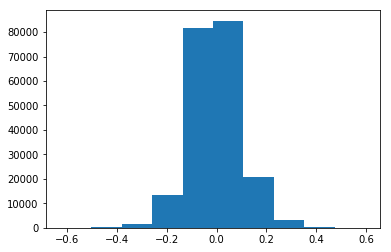

In [0]:
plt.hist(clf.predict(X))

In [0]:
clf.score(X, y)

0.4796083485136235

In [0]:
clf.get_best_score()

{'learn': {'AUC:class=0': 0.6303933729616842,
  'AUC:class=1': 0.6245578001704581,
  'AUC:class=2': 0.5,
  'Accuracy': 0.480378667493508,
  'F1:class=0': 0.16396926346263416,
  'F1:class=1': 0.6319308093077602,
  'F1:class=2': 0.21708345693023975,
  'MultiClass': -1.0262917528632611},
 'validation_0': {'AUC:class=0': 0.5122127048111488,
  'AUC:class=1': 0.6165934788597436,
  'AUC:class=2': 0.5,
  'Accuracy': 0.4430665574069016,
  'F1:class=0': 0.13677380107472373,
  'F1:class=1': 0.5956005780262448,
  'F1:class=2': 0.3251213547939706,
  'MultiClass': -1.0635494912592187}}

In [0]:
yhat = clf.predict(X)

In [0]:
yhat

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]])

In [0]:
phat = clf.predict_proba(X)
phat

array([[0.21849312, 0.45113284, 0.33037403],
       [0.16187145, 0.63460026, 0.20352829],
       [0.2608184 , 0.44322688, 0.29595472],
       ...,
       [0.2456643 , 0.28561703, 0.46871867],
       [0.26385127, 0.42901482, 0.30713391],
       [0.27085549, 0.31358621, 0.4155583 ]])

In [0]:
phat = pd.DataFrame(phat, columns=[-1, 0, 1], index=X.index)

In [0]:
phat.insert(0, 'PERMNO', X['PERMNO'])

In [0]:
phat.insert(4, 'y', y.values)

In [0]:
phat

,PERMNO,-1,0,1,y
date,,,,,
1970-01-30,10102,0.218493,0.451133,0.330374,0
1970-01-30,10137,0.161871,0.634600,0.203528,1
1970-01-30,10145,0.260818,0.443227,0.295955,0
1970-01-30,10161,0.240835,0.496787,0.262379,1
1970-01-30,10225,0.179906,0.555436,0.264658,0
1970-01-30,10233,0.275101,0.415836,0.309062,0
1970-01-30,10241,0.192536,0.528201,0.279263,0
1970-01-30,10321,0.346123,0.318860,0.335018,0
1970-01-30,10364,0.222014,0.498452,0.279533,1


In [0]:
long_portfolio = phat.groupby(level=0).apply(lambda x: x.sort_values(1, ascending=False).head(50))

In [0]:
long_portfolio = long_portfolio[(long_portfolio[1] > long_portfolio[-1]) & (long_portfolio[1] > long_portfolio[0])]

In [0]:
short_portfolio = phat.groupby(level=0).apply(lambda x: x.sort_values(-1, ascending=False).head(50))

In [0]:
sum(long_portfolio['y'] == 1) / len(long_portfolio)

0.4902127659574468

In [0]:
sum(short_portfolio['y'] == -1) / len(short_portfolio)

0.4334126984126984

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, yhat)

array([[ 5095, 44395,  4444],
       [ 2683, 86150,  4627],
       [ 2793, 48561,  7660]])

In [0]:
from collections import Counter
Counter(y.values).items()

dict_items([(0, 93460), (1, 59014), (-1, 53934)])

In [0]:
np.sum(confusion_matrix(y, yhat), axis=0)

array([ 10571, 179106,  16731])

In [0]:
np.sum(confusion_matrix(y, yhat), axis=1)

array([53934, 93460, 59014])

In [0]:
from collections import Counter
Counter(y.values).items()

dict_items([(0, 93460), (1, 59014), (-1, 53934)])

In [0]:
from collections import Counter
Counter(yhat.reshape(-1)).items()

dict_items([(0.0, 179106), (-1.0, 10571), (1.0, 16731)])

In [0]:
clf.get_best_score()

{'learn': {'AUC': 0.7292528450489044,
  'Accuracy': 0.7261443354908724,
  'Logloss': 0.5460763315254253},
 'validation_0': {'AUC': 0.5868979394435883,
  'Accuracy': 0.7027041791860148,
  'Logloss': 0.5996015859737777}}

In [0]:
clf.predict_proba(X_test)

array([[0.63444041, 0.36555959],
       [0.59808999, 0.40191001],
       [0.65591651, 0.34408349],
       ...,
       [0.67841737, 0.32158263],
       [0.66734147, 0.33265853],
       [0.6992054 , 0.3007946 ]])

([array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0000e+00,
         3.0700e+02, 3.9250e+03, 1.5452e+04, 2.9916e+04, 5.3080e+03]),
  array([5.3080e+03, 2.9916e+04, 1.5452e+04, 3.9250e+03, 3.0700e+02,
         7.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])],
 array([0.1639855, 0.2311884, 0.2983913, 0.3655942, 0.4327971, 0.5      ,
        0.5672029, 0.6344058, 0.7016087, 0.7688116, 0.8360145]),
 <a list of 2 Lists of Patches objects>)

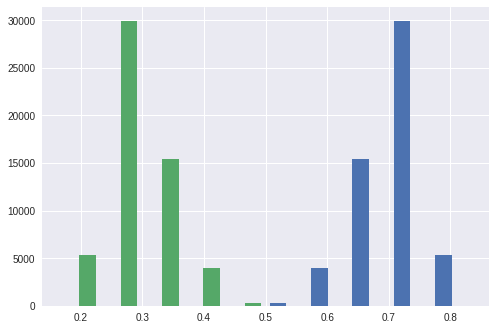

In [0]:
plt.hist(clf.predict_proba(X_test))

In [0]:
feature_list = list(fea_imp.iloc[-10:, 0])[::-1]

In [0]:
feature_list

['rd_sale',
 'DIVYIELD',
 'adv_sale',
 'staff_sale',
 'CAPEI',
 'PERMNO',
 'ptb',
 'PEG_trailing',
 'dpr',
 'inv_turn']

In [0]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

/usr/local/lib/python3.6/dist-packages/catboost/core.py:1697: UserWarning: 'fstr_type' parameter will be deprecated soon, use 'type' parameter instead
  warnings.warn("'fstr_type' parameter will be deprecated soon, use 'type' parameter instead")


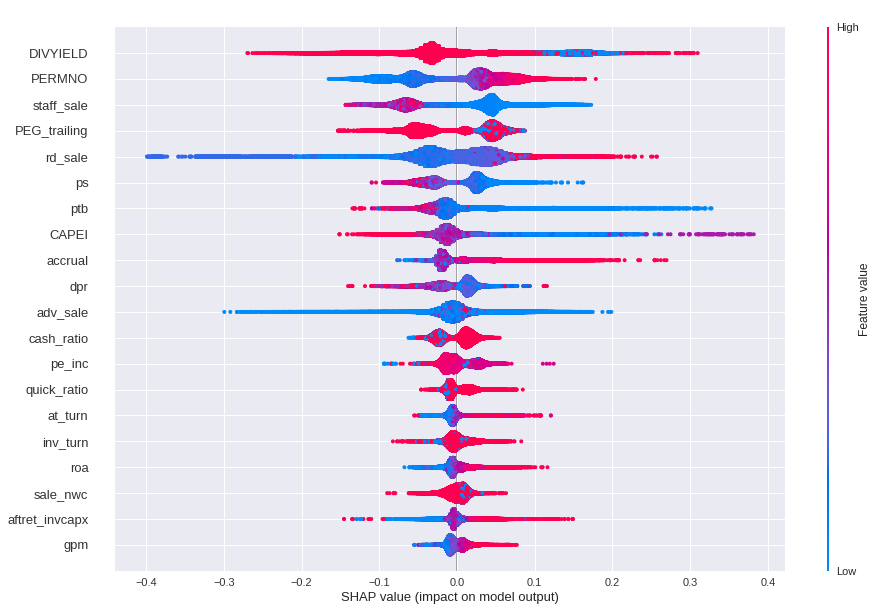

In [0]:
shap.summary_plot(shap_values, X, show=False, auto_size_plot=False, 
                  class_names=[-1, 0, 1])
plt.gcf().set_size_inches(15, 10)
plt.show()

In [0]:
f.savefig('/gdrive/My Drive/data/shap.png')

In [0]:
from catboost import Pool
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_test, y_test)
curve = get_roc_curve(clf, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

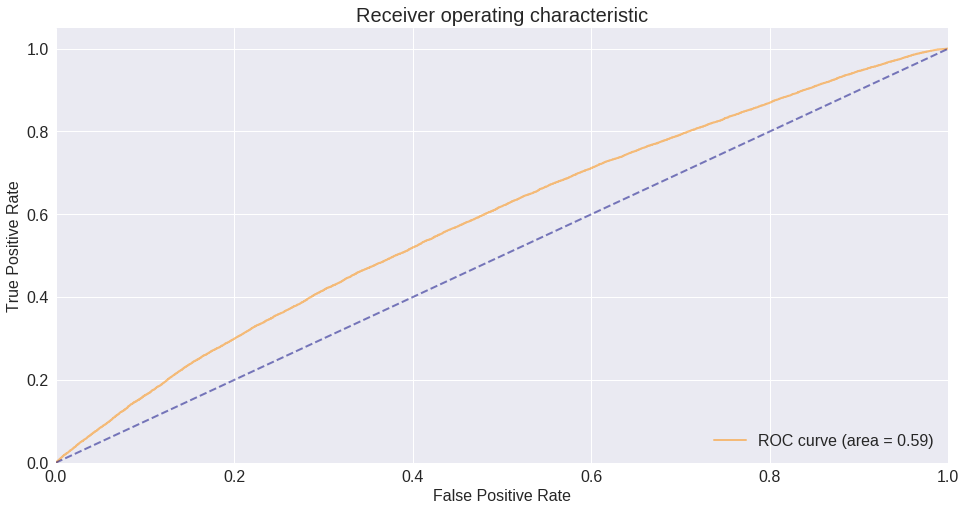

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [0]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

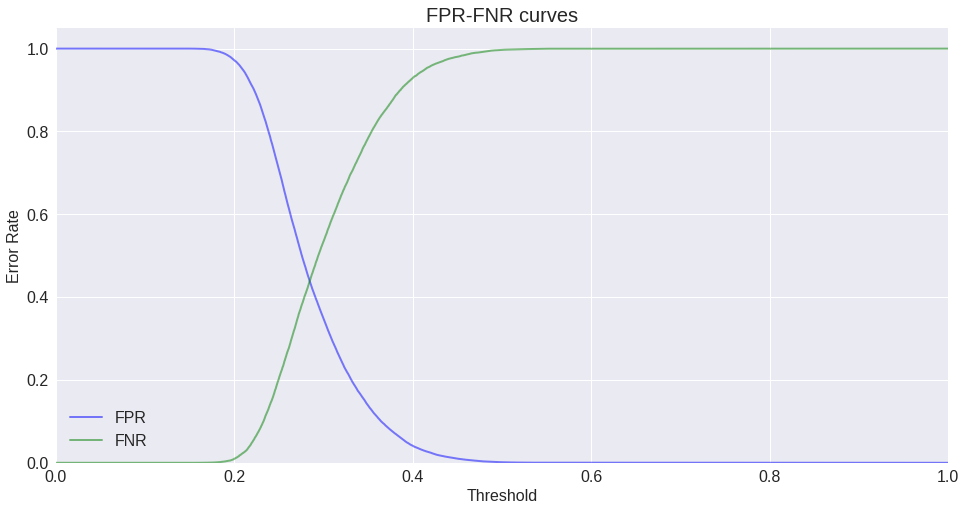

In [0]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [0]:
from catboost.utils import select_threshold

print(select_threshold(model=clf, data=eval_pool, FNR=0.01))
print(select_threshold(model=clf, data=eval_pool, FPR=0.01))

0.20044637725678202
0.4499609321788909


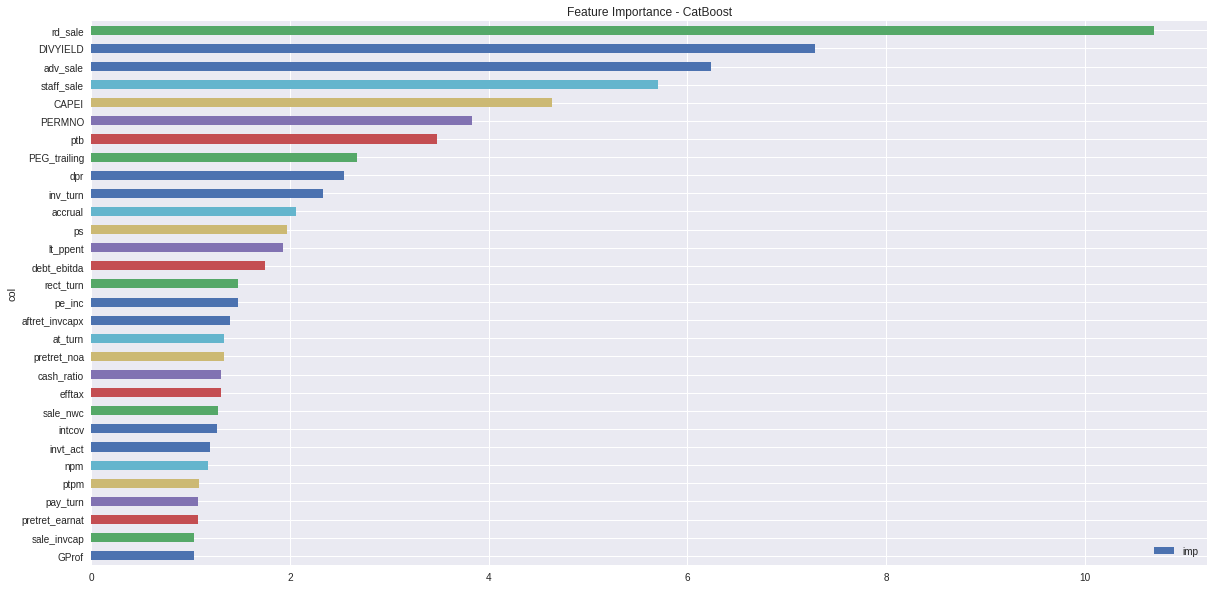

In [0]:
fea_imp = pd.DataFrame({'imp': clf.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.title('Feature Importance - CatBoost')
plt.show()